In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import decomposition
import numpy as np
from itertools import combinations
import pandas as pd
import gensim
from gensim.models.keyedvectors import KeyedVectors
import time

In [11]:
tweet = pd.read_csv("/content/drive/My Drive/tweetJanAndFebAndMarchAfterPre2AfterRemovingStopWordsandNormalization.csv", encoding='utf-8')

In [12]:
tweet.head()

,id,full_text,full_text2,pred_topic_num
0,1212214062169370625,اول يوم ادلب إدلب تحت النار اللهم انصرهم ظالم ...,ادلب ادلب النار اللهم انصرهم ظالم اللهم كربهم ...,7
1,1212428525170495493,صدر قرار وزير الصحة بتكليف الاستاذ سعيد جابر ا...,صدر قرار وزير الصحه بتكليف الاستاذ سعيد جابر ا...,8
2,1212491871890673664,معاناة المسلمين بالهند اللهم انصر المسلمين الم...,معاناه المسلمين بالهند اللهم انصر المسلمين الم...,7
3,1212506547504459782,سذاجة الصين اقتصادها أظهر هشاشته أزمتها الأخير...,سذاجه الصين اقتصادها اظهر هشاشته ازمتها الاخير...,4
4,1212507756772630528,تحت سور الصين العظيم,سور الصين العظيم,4


In [44]:
tweet.dropna( inplace=True)

In [45]:
tweet.head()

,id,full_text,full_text2,pred_topic_num
0,1212214062169370625,اول يوم ادلب إدلب تحت النار اللهم انصرهم ظالم ...,ادلب ادلب النار اللهم انصرهم ظالم اللهم كربهم ...,7
1,1212428525170495493,صدر قرار وزير الصحة بتكليف الاستاذ سعيد جابر ا...,صدر قرار وزير الصحه بتكليف الاستاذ سعيد جابر ا...,8
2,1212491871890673664,معاناة المسلمين بالهند اللهم انصر المسلمين الم...,معاناه المسلمين بالهند اللهم انصر المسلمين الم...,7
3,1212506547504459782,سذاجة الصين اقتصادها أظهر هشاشته أزمتها الأخير...,سذاجه الصين اقتصادها اظهر هشاشته ازمتها الاخير...,4
4,1212507756772630528,تحت سور الصين العظيم,سور الصين العظيم,4


In [37]:
model_word2vec = gensim.models.Word2Vec.load("/content/drive/My Drive/modelJanFebMarch1PreproccesedwithwordLess3WithNorm.model")

In [46]:
Tfidf_vect = TfidfVectorizer(min_df=5, max_features=500)
Tfidf_vect.fit(tweet['full_text2'])
X_Tfidf = Tfidf_vect.transform(tweet['full_text2'])

In [47]:
terms = Tfidf_vect.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 500 distinct terms


In [48]:


# define number of topics 
kmin, kmax = 4, 15
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    start = time.time()
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform(X_Tfidf )
    H = model.components_    
    # store for later
    end = time.time()
    print("fitted")
    print("The total time is : "+str((end - start)/60)+" minutes ")
    
    topic_models.append( (k,W,H) )

Applying NMF for k=4 ...
fitted
The total time is : 0.07257672150929768 minutes 
Applying NMF for k=5 ...
fitted
The total time is : 0.10623568296432495 minutes 
Applying NMF for k=6 ...
fitted
The total time is : 0.13228927850723265 minutes 
Applying NMF for k=7 ...
fitted
The total time is : 0.14024958610534669 minutes 
Applying NMF for k=8 ...
fitted
The total time is : 0.1608952323595683 minutes 
Applying NMF for k=9 ...
fitted
The total time is : 0.28044063647588097 minutes 
Applying NMF for k=10 ...
fitted
The total time is : 0.43103407621383666 minutes 
Applying NMF for k=11 ...
fitted
The total time is : 0.3734340031941732 minutes 
Applying NMF for k=12 ...
fitted
The total time is : 0.4194932460784912 minutes 
Applying NMF for k=13 ...
fitted
The total time is : 0.6232354680697123 minutes 
Applying NMF for k=14 ...
fitted
The total time is : 0.6478894750277201 minutes 
Applying NMF for k=15 ...
fitted
The total time is : 0.27739407618840534 minutes 


In [49]:
# Topic coherence approach to evaluate the different NMF topic models that we created previously
# TC-W2V coherence measure by incorporating Word2vec model.

def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [50]:
# Topic descriptor function (i.e. list of top terms) for each topic 
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [51]:
#process each of the models for different values of k

k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( model_word2vec, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.2090
K=05: Coherence=0.2142
K=06: Coherence=0.2193
K=07: Coherence=0.2299
K=08: Coherence=0.2353
K=09: Coherence=0.2367
K=10: Coherence=0.2251
K=11: Coherence=0.2278
K=12: Coherence=0.2303
K=13: Coherence=0.2297
K=14: Coherence=0.2251
K=15: Coherence=0.2233


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # Remove the CWD from sys.path while we load stuff.


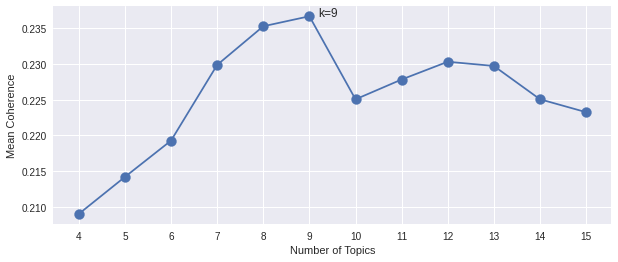

In [53]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
matplotlib.rcParams.update({"font.size": 30})
fig = plt.figure(figsize=(10,4))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=100)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=12)
# show the plot
#plt.savefig('TC-W2VBlue.eps',format='eps',dpi=900)
plt.show()

In [55]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: كورونا, فايروس, الكويت, الجديد, مرض, السعوديه, لبنان, اللهم, مصر, علاج
Topic 02: الصين, امريكا, العالم, اتفاقيه, المسلمين, العراق, دوله, ايران, الفيروس, يعني
Topic 03: الكورونا, عشان, مرض, مصر, علاج, يعني, احنا, اخطر, الناس, فايروس
Topic 04: الله, المسلمين, شاء, سبحان, اللهم, عليهم, يستر, باذن, حراره, المرض
Topic 05: فيروس, الجديد, انتشار, المستجد, العالم, تفشي, الفيروس, الوقايه, الصينيه, الصيني
Topic 06: اصابه, بفيروس, حاله, وفاه, بكورونا, تعلن, ووهان, جديده, تسجيل, قطر
Topic 07: وباء, العالم, اللهم, انتشار, الناس, الوباء, ايران, عالمي, يعني, مرض
Topic 08: كمامات, عشان, الناس, يعني, كمامه, ليش, بدون, احنا, مصر, لازم
Topic 09: الصحه, العالميه, وزاره, منظمه, مصر, وزيره, وزير, الكويت, فايروس, عاجل
